# Create AI commentary of a cricket match with GPT's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context widnow to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API


In [ ]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video
import base64
import time
import openai
import os
import requests

## 1. Using GPT's visual capabilities to get a description of a video


First we use OpenCV to extract frames from a cricket [video](https://www.youtube.com/watch?v=_iICAyby1XU&ab_channel=SportsCentral) of a match between south africa and pakistan:


In [ ]:
import cv2
import base64

video = cv2.VideoCapture("raw_cricket_clip.mp4")

# Get the FPS (frames per second) of the video before starting the read loop
fps = video.get(cv2.CAP_PROP_FPS)

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

# Release the video capture object after reading all frames
video.release()

# Print the total number of frames read
print(len(base64Frames), "frames read.")

# Calculate the duration of the video in seconds and store it in 'video_duration'
video_duration = len(base64Frames) / fps if fps else 0
video_duration = int(video_duration)

# Now video_duration holds the duration of the video in seconds
print("Duration of the video in seconds:", video_duration)


345 frames read.
Duration of the video in seconds: 11


Display frames to make sure we've read them in correctly:


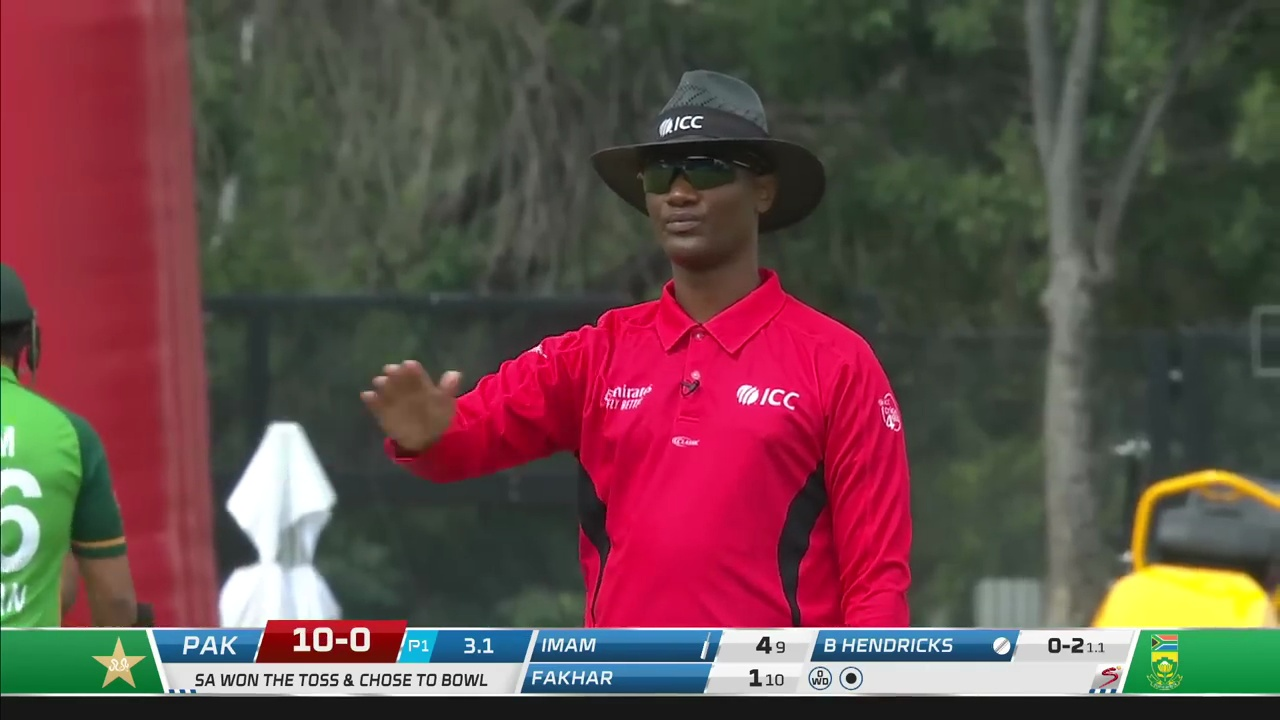

In [ ]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Once we have the video frames we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a commentary for this video in the style of Harsha Bhogle. Using the same video frames we prompt GPT to give us a short script:

In [ ]:
user_prompt = f"""\
These are frames of sequence of play in a cricket match.
You have to create a short cricket commentary in the style of Harsha Bhogle to describe the sequence of play in the frames.
Use capitalization of text and exclamation marks wherever enthusiasm is required.
Use text present at the bottom of frames to improve the commentary.
Keep it short such that the commentary can be spoken in {video_duration} seconds."""

PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            user_prompt,
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::10]),
        ]
    }
]
params = {
    "temperature":0.2,
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": openai.api_key,
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 100,
}

result = openai.ChatCompletion.create(**params)
commentary = result.choices[0].message.content
print(commentary)

"Here we go, Hendricks steaming in... and it's a CRACKING shot! Off the back foot, punched through the covers, racing away to the boundary. That's FOUR! Beautifully timed, the batsman really leaning into that one. The fielders can only watch it go - it's pure class, pure timing. And that's what you get with a bit of width on offer. Pakistan moves into double digits with style. Exquisite cricket!"


## Refine the commentary

Taking the best bits, and syncing it with the video

In [ ]:
shorten_prompt = f"""\
Your role is to format the given cricket commentary so that it can be spoken in {video_duration} seconds.
Capitalize words and add exclamation mark where enthusiasm is warranted."""
user_prompt = f"transcript:{commentary}\ncommentary:"

PROMPT_MESSAGES = [
       {"role": "system", "content": shorten_prompt},
       {"role": "user", "content": user_prompt}    
]
params = {
    "temperature":0.3,
    "model": "gpt-4",
    "messages": PROMPT_MESSAGES,
    "api_key": openai.api_key,
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 100,
}

result = openai.ChatCompletion.create(**params)
short_commentary = result.choices[0].message.content
print(short_commentary)

"Good morning! Hendricks steaming in... CRACKING shot! Punched off the back foot through the covers, it's FOUR! Pure class, pure timing. Pakistan moves into double digits with style. Exquisite cricket!"


Now we can pass the script to the TTS API where it will generate a mp3 of the voiceover:


In [ ]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {openai.api_key}",
    },
    json={
        "model": "tts-1-hd",
        "input": short_commentary,
        "voice": "nova",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)

In [15]:
if response.status_code == 200:
    audio = b""
    for chunk in response.iter_content(chunk_size=1024 * 1024):
        audio += chunk

    # Save the audio to a file
    with open("raw_generated_audio.mp3", "wb") as audio_file:
        audio_file.write(audio)
    print("Audio saved as 'raw_generated_audio.mp3'.")
else:
    print(f"Failed to generate audio. Status code: {response.status_code}")
    print(f"Response: {response.text}")

Audio saved as 'raw_generated_audio.mp3'.
